# LightGBMで外れ値を検出

In [38]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

pd.options.display.max_columns = 100
pd.options.display.max_rows = 20

In [39]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [40]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [41]:
def add_distance_diff(df, is_train=True):
    # shift(1): 上のやつが1個下に下がる → 前のデータ
    # shift(-1): 下のやつが1個上に上がる → 次のデータ
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)

    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']

    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']

    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    if is_train == True:
        df['latDeg_gt_prev'] = df['latDeg_gt'].shift(1)
        df['latDeg_gt_next'] = df['latDeg_gt'].shift(-1)
        df['lngDeg_gt_prev'] = df['lngDeg_gt'].shift(1)
        df['lngDeg_gt_next'] = df['lngDeg_gt'].shift(-1)
        df['latDeg_gt_prev_diff'] = df['latDeg_gt'] - df['latDeg_gt_prev']
        df['latDeg_gt_next_diff'] = df['latDeg_gt_next'] - df['latDeg_gt']
        df['lngDeg_gt_prev_diff'] = df['lngDeg_gt'] - df['lngDeg_gt_prev']
        df['lngDeg_gt_next_diff'] = df['lngDeg_gt_next'] - df['lngDeg_gt']
        df['dist_gt_prev'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_prev'], df['lngDeg_gt_prev'])
        df['dist_gt_next'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_next'], df['lngDeg_gt_next'])
        df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                            'latDeg_gt_prev', 'lngDeg_gt_prev', 'dist_gt_prev',
                                            'latDeg_prev_diff', 'latDeg_gt_prev_diff',
                                            'lngDeg_prev_diff', 'lngDeg_gt_prev_diff']] = np.nan
        
        df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                            'latDeg_gt_next', 'lngDeg_gt_next', 'dist_gt_next',
                                            'latDeg_next_diff', 'latDeg_gt_next_diff',
                                            'lngDeg_next_diff', 'lngDeg_gt_next_diff']] = np.nan
    

    
    else:
        df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                            'latDeg_prev_diff', 'lngDeg_prev_diff']] = np.nan
        
        df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                            'latDeg_next_diff', 'lngDeg_next_diff']] = np.nan
    
    return df

In [42]:
INPUT = '../input/google-smartphone-decimeter-challenge'

# filtered_train = pd.read_csv(INPUT + '/' + 'baseline_locations_filtered_train.csv')
filtered_train = pd.read_csv('../output/filtered_nb025.csv')
filtered_test = pd.read_csv('../output/sub_nb024.csv')
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')    
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

# ground truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))

gts = []
for gt_file in gt_files:
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

# Preprocessing

In [43]:
ground_truth = ground_truth.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt',
                                           'heightAboveWgs84EllipsoidM':'heightAboveWgs84EllipsoidM_gt'})
                                           
# sub形式にしたfiltered_train済みbaselineを、gtとmergeできる形にする
filtered_train['collectionName'] = filtered_train['phone'].apply(lambda x: x.split('_')[0])
filtered_train['phoneName'] = filtered_train['phone'].apply(lambda x: x.split('_')[1])

filtered_train = filtered_train.merge(ground_truth, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
filtered_train['dist_err'] = calc_haversine(filtered_train['latDeg_gt'], filtered_train['lngDeg_gt'], filtered_train['latDeg'], filtered_train['lngDeg'])
filtered_train = add_distance_diff(filtered_train)

In [44]:
train = filtered_train
train = train.drop(['phone', 'phone_prev', 'phone_next','collectionName'], axis=1)
train = train.drop(['latDeg_gt_prev','latDeg_gt_next', 
                    'lngDeg_gt_prev', 'lngDeg_gt_next',
                    'latDeg_gt_prev_diff', 'latDeg_gt_next_diff', 
                    'lngDeg_gt_prev_diff','lngDeg_gt_next_diff', 
                    'dist_gt_prev', 'dist_gt_next','phoneName', 'latDeg_gt', 'lngDeg_gt', 'heightAboveWgs84EllipsoidM_gt',
       'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree',], axis=1)

# InterQuantile Range
IQR = filtered_train['dist_err'].quantile(0.75)-filtered_train['dist_err'].quantile(0.25)
# threshold
thr = filtered_train['dist_err'].quantile(0.75) + 1.5*IQR
train['target'] = 0
train.loc[train['dist_err'] > thr, 'target'] = 1
train = train.drop('dist_err', axis=1)
target = train.pop('target')

In [45]:
test = add_distance_diff(filtered_test, is_train=False)
test = test.drop(['phone', 'phone_prev', 'phone_next'], axis=1)

In [63]:
train = train.drop([
                      'millisSinceGpsEpoch',
                      'latDeg',
                      'lngDeg',
                      'latDeg_prev',
                      'latDeg_next',
                      'lngDeg_prev',
                      'lngDeg_next',
                      ], axis=1)
test = test.drop([
                      'millisSinceGpsEpoch',
                      'latDeg',
                      'lngDeg',
                      'latDeg_prev',
                      'latDeg_next',
                      'lngDeg_prev',
                      'lngDeg_next',
                      ], axis=1)                 
print(train.columns)
print(test.columns)

Index(['latDeg_prev_diff', 'latDeg_next_diff', 'lngDeg_prev_diff',
       'lngDeg_next_diff', 'dist_prev', 'dist_next'],
      dtype='object')
Index(['latDeg_prev_diff', 'latDeg_next_diff', 'lngDeg_prev_diff',
       'lngDeg_next_diff', 'dist_prev', 'dist_next'],
      dtype='object')
0         1
1         1
2         0
3         0
4         0
         ..
131337    0
131338    0
131339    0
131340    0
131341    0
Name: target, Length: 131342, dtype: int64


# LightGBM

In [64]:
import lightgbm as lgb
from sklearn.metrics import f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
for i, (trn_idx, val_idx) in enumerate(skf.split(train, target)):
    print(i, '-'*50)
    trn_x = train.iloc[trn_idx]
    val_x = train.iloc[val_idx]
    trn_y = target.iloc[trn_idx]
    val_y = target.iloc[val_idx]

    lgb_train = lgb.Dataset(trn_x, trn_y)
    lgb_eval = lgb.Dataset(val_x, val_y)

    params = {'objective':'binary'}

    model = lgb.train(params, lgb_train, num_boost_round=9999,
    early_stopping_rounds=100, valid_sets=[lgb_train, lgb_eval], verbose_eval=-1)

    val_pred = model.predict(val_x)
    score = f1_score(val_y, np.round(val_pred))
    print(f'f1 score: {score:.4f}')
    
pred = model.predict(test)

0 --------------------------------------------------
[LightGBM] [Info] Number of positive: 9876, number of negative: 95197
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 105073, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093992 -> initscore=-2.265841
[LightGBM] [Info] Start training from score -2.265841
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.16678	valid_1's binary_logloss: 0.206961
f1 score: 0.2522
1 --------------------------------------------------
[LightGBM] [Info] Number of positive: 9876, number of negative: 95197
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_col_wise=tru

<AxesSubplot:xlabel='importance'>

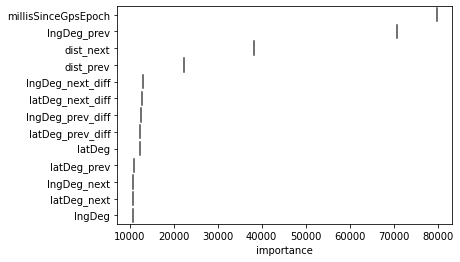

In [13]:
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
# display(importance)
sns.boxenplot(data=importance, x='importance', y=importance.index)

# Adversal Validation

In [60]:
from sklearn.metrics import roc_auc_score
train_ad = train.copy()
test_ad = test.copy()
train_ad['is_train'] = 1
test_ad['is_train'] = 0
all_df = pd.concat([train_ad, test_ad], axis=0)
all_df = all_df.fillna(-9999)
all_df = all_df.reset_index(drop=True)
target_ad = all_df['is_train'].astype(int)
all_df = all_df.drop(columns=['is_train'])
all_df = all_df.drop([
                      'millisSinceGpsEpoch',
                      'latDeg',
                      'lngDeg',
                      'latDeg_prev',
                      'latDeg_next',
                      'lngDeg_prev',
                      'lngDeg_next',
#                        'dist_prev',
#                        'dist_next'
                        ], axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
for i, (trn_idx, val_idx) in enumerate(skf.split(all_df, target_ad)):
    print(f'Fold {i}', '-'*50)
    trn_x = all_df.iloc[trn_idx]
    val_x = all_df.iloc[val_idx]
    trn_y = target_ad.iloc[trn_idx]
    val_y = target_ad.iloc[val_idx]

    lgb_train = lgb.Dataset(trn_x, trn_y)
    lgb_eval = lgb.Dataset(val_x, val_y)

    params = {'objective':'binary'}

    model_ad = lgb.train(params, lgb_train, num_boost_round=9999,
    early_stopping_rounds=100, valid_sets=[lgb_train, lgb_eval], verbose_eval=-1)
    val_pred_ad = model_ad.predict(val_x)
    score = roc_auc_score(val_y, np.round(val_pred_ad))
    print(f'auc: {score:.4f}')

Fold 0 --------------------------------------------------
[LightGBM] [Info] Number of positive: 105073, number of negative: 73189
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 178262, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589430 -> initscore=0.361610
[LightGBM] [Info] Start training from score 0.361610
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3403]	training's binary_logloss: 0.419215	valid_1's binary_logloss: 0.55202
auc: 0.6780
Fold 1 --------------------------------------------------
[LightGBM] [Info] Number of positive: 105073, number of negative: 73189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the o

<AxesSubplot:xlabel='importance'>

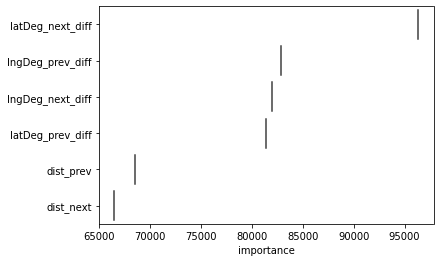

In [62]:
importance = pd.DataFrame(model_ad.feature_importance(importance_type='gain'), index=all_df.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
# display(importance)
sns.boxenplot(data=importance, x='importance', y=importance.index)

In [149]:
model.feature_name()

['latDeg_prev_diff',
 'latDeg_next_diff',
 'lngDeg_prev_diff',
 'lngDeg_next_diff',
 'dist_prev',
 'dist_next']